# Threshold analysis CR

## Add THI data for threshold analysis of conception rate
This script assumes that the following scripts have been run in the following order to generate basic dataframe for conception rate, MY and weather data
- BuildingDataset.ipynb
    * Results in "updateDF.csv" which contain the following columns:
        * SE_Number,LactationNumber,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,
        * BirthDate,Father_SE_Number,Mother_SE_Number,CalvingDate,upper_limit,InseminationDate,PregnancyCheckDate,PregnancyStatus,DryOffDate,
        * CullingDate,ExitReason_PrimaryReasonKok,ExitReason_SecondaryReason1Kok,ExitReason_SecondaryReason2Kok,CullingReason1,CullingReason2,
        * next_calving,next_ins,prev_ins,prev_calf

- FertilityTraits.ipynb
    * Results in "fertilityDF_W61/68.csv" which contains the full dataframe with one observation per insemination and including pregnancy analysis within insemination (i.e. may have more than one observation per insemination)
- HS_fertility_FilteringDataframe.ipynb
    * Results in "fertility_filtered61/68.csv" which contains the following columns with one observation per insemination:
        * FarmName_Pseudo,SE_Number,Breed,LactationNumber,Parity,InseminationDate,HYS,HS,THI_3D_Above_68,HS_sum,Milk_Kg,CFI,CLI,FLI,NINS,CR0,CI,GL,DIMatINS

## Threshold analysis
The following script is to determine critical temperature/THI thresholds where conception rate declines.

In [1]:
import pandas as pd
import numpy as np

# Load conception rate

In [3]:
df = pd.read_csv("../Data/MergedData/fertilityDF_W_MY68_filtered.csv", low_memory=False)

col_keep = ["SE_Number", "LactationNumber", "CalvingDate", "InseminationDate", "next_ins", "prev_ins", "prev_calf", "upper_limit", "CR0"]
df_fert = df[col_keep]
df_fert = df_fert.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
df_fert

,SE_Number,LactationNumber,CalvingDate,InseminationDate,next_ins,prev_ins,prev_calf,upper_limit,CR0
0,SE-064c0cec-1189,7.0,2021-06-24,2021-08-17,NaN,NaN,2020-05-20,2022-05-25,1.0
2,SE-064c0cec-1189,8.0,2022-05-25,2022-07-06,2022-08-16,NaN,2021-06-24,2022-12-20,0.0
17,SE-064c0cec-1189,8.0,2022-05-25,2022-08-16,NaN,2022-07-06,2021-06-24,2022-12-20,0.0
77,SE-30dc5787-1389,5.0,2021-04-26,2021-06-28,NaN,NaN,2020-06-07,2022-04-11,1.0
79,SE-30dc5787-1389,6.0,2022-04-11,2022-05-27,2022-06-18,NaN,2021-04-26,2023-04-25,0.0
...,...,...,...,...,...,...,...,...,...
106642,SE-f454e660-767,1.0,2023-02-14,2023-07-03,NaN,2023-05-04,NaN,2024-02-14,1.0
106657,SE-f454e660-789,1.0,2023-07-14,2023-08-28,NaN,NaN,NaN,2024-07-13,NaN
106672,SE-f454e660-796,1.0,2023-04-11,2023-07-08,2023-07-27,NaN,NaN,2024-04-10,0.0
106687,SE-f454e660-796,1.0,2023-04-11,2023-07-27,NaN,2023-07-08,NaN,2024-04-10,1.0


In [48]:
"""
# Find example cow, put as comment once script works
SE_Number = ["SE-064c0cec-1189"] #["SE-5c06d92d-3114"] #["SE-a756bc39-1143"]
df_fert = df_fert[df_fert["SE_Number"].isin(SE_Number)]
"""

df_fert

,SE_Number,LactationNumber,CalvingDate,InseminationDate,next_ins,prev_ins,shift_calf,upper_limit,CR0
0,SE-064c0cec-1189,7.0,2021-06-24,2021-08-17,NaN,NaN,2022-05-25,2022-05-18,1.0
2,SE-064c0cec-1189,8.0,2022-05-25,2022-07-06,2022-08-16,NaN,NaN,2022-12-20,0.0
3,SE-064c0cec-1189,8.0,2022-05-25,2022-08-16,NaN,2022-07-06,NaN,2022-12-20,0.0
5,SE-30dc5787-1389,5.0,2021-04-26,2021-06-28,NaN,NaN,2022-04-11,2022-03-24,1.0
7,SE-30dc5787-1389,6.0,2022-04-11,2022-05-27,2022-06-18,NaN,NaN,2023-04-25,0.0
...,...,...,...,...,...,...,...,...,...
4590,SE-f454e660-0785,1.0,2023-03-05,2023-07-29,NaN,NaN,NaN,2024-03-29,1.0
4591,SE-f454e660-0790,1.0,2023-05-22,2023-07-16,2023-08-07,NaN,NaN,2024-04-30,0.0
4593,SE-f454e660-0790,1.0,2023-05-22,2023-08-07,2023-08-28,2023-07-16,NaN,2024-04-30,0.0
4595,SE-f454e660-0790,1.0,2023-05-22,2023-08-28,NaN,2023-08-07,NaN,2024-04-30,1.0


In [4]:
# Make start and stop for inseminations
df_fert = df_fert.copy()
df_fert["StartIns"] = df_fert["InseminationDate"]
df_fert["StopIns"] = df_fert["next_ins"].fillna(df_fert["prev_calf"]).fillna(df_fert["upper_limit"])
col_keep = ["SE_Number", "LactationNumber", "CalvingDate", "InseminationDate", "StartIns", "StopIns", "CR0"]
df_fert = df_fert[col_keep]

df_fert

# Load MY and weather data

In [5]:
df_THI = pd.read_csv("../Data/MergedData/MY_weather.csv", low_memory=False)

In [6]:
"""
# Matching weather data for example cow, put as comment once script works
SE_Number = ["SE-064c0cec-1189"] # ["SE-5c06d92d-3114"] #["SE-a756bc39-1143"]
df_THI = df_THI[df_THI["SE_Number"].isin(SE_Number)]
"""
col_keep = ["SE_Number", "LactationNumber", "StartDate"] #, "StartTime", "THI_adj", "MeanTHI_adj"]
df_THI = df_THI[col_keep]

df_THI = df_THI.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate"]) #, "StartTime"])
df_THI


,SE_Number,LactationNumber,StartDate
0,SE-27c3257a-1492,1.0,2022-10-25
1,SE-27c3257a-1492,1.0,2022-10-26
2,SE-27c3257a-1492,1.0,2022-10-27
3,SE-27c3257a-1492,1.0,2022-10-28
4,SE-27c3257a-1492,1.0,2022-10-29
...,...,...,...
2594000,SE-fcdf259d-0044-0,10.0,2023-07-24
2594001,SE-fcdf259d-0044-0,10.0,2023-07-25
2594002,SE-fcdf259d-0044-0,10.0,2023-07-26
2594003,SE-fcdf259d-0044-0,10.0,2023-07-27


Make helper columns to sort insemination data into DF

In [7]:
# Find first and last date within each lactation in MY_weather.csv file
df_THI["StartDate"] = pd.to_datetime(df_THI["StartDate"])

result = df_THI.groupby(["SE_Number", "LactationNumber"])["StartDate"].agg(
    FirstDateMY="min",
    LastDateMY="max"
).reset_index()

result

,SE_Number,LactationNumber,FirstDateMY,LastDateMY
0,SE-064c0cec-1189,7.0,2022-01-01,2022-05-25
1,SE-064c0cec-1189,8.0,2022-05-25,2022-12-20
2,SE-27c3257a-1492,1.0,2022-10-25,2023-11-19
3,SE-27c3257a-1492,2.0,2023-11-19,2024-08-18
4,SE-30dc5787-1389,5.0,2022-01-01,2022-04-11
...,...,...,...,...
3983,SE-f454e660-796,1.0,2023-04-11,2024-04-10
3984,SE-f454e660-799,1.0,2023-05-27,2024-05-26
3985,SE-f454e660-810,1.0,2023-05-25,2024-05-24
3986,SE-fcdf259d-0044-0,9.0,2022-01-01,2022-06-21


In [8]:
# Add these variables to original df
df_THI = pd.merge(df_THI, result, on=["SE_Number", "LactationNumber"])
df_THI

,SE_Number,LactationNumber,StartDate,FirstDateMY,LastDateMY
0,SE-27c3257a-1492,1.0,2022-10-25,2022-10-25,2023-11-19
1,SE-27c3257a-1492,1.0,2022-10-26,2022-10-25,2023-11-19
2,SE-27c3257a-1492,1.0,2022-10-27,2022-10-25,2023-11-19
3,SE-27c3257a-1492,1.0,2022-10-28,2022-10-25,2023-11-19
4,SE-27c3257a-1492,1.0,2022-10-29,2022-10-25,2023-11-19
...,...,...,...,...,...
1143155,SE-fcdf259d-0044-0,10.0,2023-07-24,2022-06-21,2023-07-28
1143156,SE-fcdf259d-0044-0,10.0,2023-07-25,2022-06-21,2023-07-28
1143157,SE-fcdf259d-0044-0,10.0,2023-07-26,2022-06-21,2023-07-28
1143158,SE-fcdf259d-0044-0,10.0,2023-07-27,2022-06-21,2023-07-28


In [9]:
df_fert

,SE_Number,LactationNumber,CalvingDate,InseminationDate,StartIns,StopIns,CR0
0,SE-064c0cec-1189,7.0,2021-06-24,2021-08-17,2021-08-17,2020-05-20,1.0
2,SE-064c0cec-1189,8.0,2022-05-25,2022-07-06,2022-07-06,2022-08-16,0.0
17,SE-064c0cec-1189,8.0,2022-05-25,2022-08-16,2022-08-16,2021-06-24,0.0
77,SE-30dc5787-1389,5.0,2021-04-26,2021-06-28,2021-06-28,2020-06-07,1.0
79,SE-30dc5787-1389,6.0,2022-04-11,2022-05-27,2022-05-27,2022-06-18,0.0
...,...,...,...,...,...,...,...
106642,SE-f454e660-767,1.0,2023-02-14,2023-07-03,2023-07-03,2024-02-14,1.0
106657,SE-f454e660-789,1.0,2023-07-14,2023-08-28,2023-08-28,2024-07-13,NaN
106672,SE-f454e660-796,1.0,2023-04-11,2023-07-08,2023-07-08,2023-07-27,0.0
106687,SE-f454e660-796,1.0,2023-04-11,2023-07-27,2023-07-27,2024-04-10,1.0


In [10]:
# Merge ins and CR data with MY StartDates
df = pd.merge(df_fert, df_THI, on=["SE_Number", "LactationNumber"], how="left")
df.to_csv("../Data/test.csv", index=False)

In [11]:
# Filter and keep only data within window 
df.loc[(df["StartDate"] < df["StartIns"]) | (df["StartDate"] > df["StopIns"]), "InseminationDate"] = np.nan
df.loc[df['InseminationDate'].isna(), 'CR0'] = np.nan
col_keep = ["SE_Number", "LactationNumber", "InseminationDate", "StartDate", "CR0"]
df = df[col_keep]

df = df[df["InseminationDate"].notna()]
df.to_csv("../Data/test.csv", index=False)

Add all StartDates

In [12]:
col_keep = ["SE_Number", "LactationNumber", "StartDate"]
df_THI = df_THI[col_keep]

df = pd.merge(df, df_THI, on=["SE_Number", "LactationNumber", "StartDate"], how="outer")
df.to_csv("../Data/test.csv", index=False)

Add MY and weather data

In [13]:
df_THI = pd.read_csv("../Data/MergedData/MY_weather.csv", low_memory=False)

"""
# Matching weather data for example cow, put as comment once script works
SE_Number = ["SE-064c0cec-1189"] # ["SE-5c06d92d-3114"] #["SE-a756bc39-1143"]
df_THI = df_THI[df_THI["SE_Number"].isin(SE_Number)]
"""

# Keep only THI, temp and MY data
col_keep = ["SE_Number", "LactationNumber", "StartDate", "StartTime", "THI_adj", "MeanTHI_adj", "Temperature", "MeanTemperature", "TotalYield"]
df_THI = df_THI[col_keep]

df_THI = df_THI.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime"])
df_THI

,SE_Number,LactationNumber,StartDate,StartTime,THI_adj,MeanTHI_adj,Temperature,MeanTemperature,TotalYield
0,SE-27c3257a-1492,1.0,2022-10-25,NaN,NaN,50.931353,NaN,11.675000,NaN
1,SE-27c3257a-1492,1.0,2022-10-26,NaN,NaN,50.415844,NaN,10.433333,NaN
2,SE-27c3257a-1492,1.0,2022-10-27,NaN,NaN,52.105992,NaN,11.766667,NaN
3,SE-27c3257a-1492,1.0,2022-10-28,NaN,NaN,54.750190,NaN,12.541667,NaN
4,SE-27c3257a-1492,1.0,2022-10-29,NaN,NaN,48.208112,NaN,12.233333,NaN
...,...,...,...,...,...,...,...,...,...
2594000,SE-fcdf259d-0044-0,10.0,2023-07-24,NaN,NaN,61.268196,NaN,16.825000,NaN
2594001,SE-fcdf259d-0044-0,10.0,2023-07-25,NaN,NaN,63.587983,NaN,17.658333,NaN
2594002,SE-fcdf259d-0044-0,10.0,2023-07-26,NaN,NaN,59.368844,NaN,16.841667,NaN
2594003,SE-fcdf259d-0044-0,10.0,2023-07-27,NaN,NaN,59.559829,NaN,16.054167,NaN


Edit THI and MY data

In [14]:
# Fill THI_adj where missing data due to not milked or missing time stamp in milking records
df_THI['THI_adj'] = df_THI['THI_adj'].fillna(df_THI['MeanTHI_adj'])
df_THI["Temperature"] = df_THI["Temperature"].fillna(df_THI["MeanTemperature"])

In [15]:
# Aggregate THI data to mean value per day
df_THI = df_THI.groupby(['SE_Number', 'LactationNumber', 'StartDate']).agg({
    'THI_adj': 'mean',
    "Temperature": "mean",
    "TotalYield": "sum"
}).reset_index()

df_THI.rename(columns={'THI_adj': 'MeanTHI_adj', "Temperature": "MeanTemp"}, inplace=True)
df_THI

,SE_Number,LactationNumber,StartDate,MeanTHI_adj,MeanTemp,TotalYield
0,SE-064c0cec-1189,7.0,2022-01-01,28.198350,-3.100000,30.77
1,SE-064c0cec-1189,7.0,2022-01-02,33.686833,-0.266667,48.22
2,SE-064c0cec-1189,7.0,2022-01-03,37.561110,2.850000,30.53
3,SE-064c0cec-1189,7.0,2022-01-04,31.044000,-0.800000,42.26
4,SE-064c0cec-1189,7.0,2022-01-05,26.800720,-4.000000,38.49
...,...,...,...,...,...,...
1143155,SE-fcdf259d-0044-0,10.0,2023-07-24,61.268196,16.825000,0.00
1143156,SE-fcdf259d-0044-0,10.0,2023-07-25,63.587983,17.658333,0.00
1143157,SE-fcdf259d-0044-0,10.0,2023-07-26,59.368844,16.841667,0.00
1143158,SE-fcdf259d-0044-0,10.0,2023-07-27,59.559829,16.054167,0.00


Merge into CR0 dataframe

In [16]:
df["StartDate"] = pd.to_datetime(df["StartDate"])
df_THI["StartDate"] = pd.to_datetime(df_THI["StartDate"]) 
df = pd.merge(df, df_THI, on=["SE_Number", "LactationNumber", "StartDate"])
df.to_csv("../Data/test.csv", index=False)

Save

In [17]:
# df.to_csv("../Data/MergedData/CR_W_MY61.csv", index=False)
df.to_csv("../Data/MergedData/CR_W_MY68.csv", index=False)

Add parity and breed

In [19]:
# df = pd.read_csv("../Data/MergedData/CR_W_MY61.csv", low_memory=False)
df = pd.read_csv("../Data/MergedData/CR_W_MY68.csv", low_memory=False)

# Make parity
df["Parity"] = df["LactationNumber"]
df.loc[(df['LactationNumber'] >= 3) & (df['LactationNumber'] <= 8), 'Parity'] = 3

In [21]:
# Add breed
# df_fert = pd.read_csv("../Data/MergedData/fertilityDF_W_MY61_filtered.csv", low_memory=False)
df_fert = pd.read_csv("../Data/MergedData/fertilityDF_W_MY68_filtered.csv", low_memory=False)

col_keep = ["SE_Number", "Breed"]
df_fert = df_fert[col_keep]
df_fert = df_fert.drop_duplicates(subset=["SE_Number"])

df = pd.merge(df, df_fert, on=["SE_Number"], how="left")
df

,SE_Number,LactationNumber,InseminationDate,StartDate,CR0,MeanTHI_adj,MeanTemp,TotalYield,Parity,Breed
0,SE-064c0cec-1189,7.0,NaN,2022-01-01,NaN,28.198350,-3.100000,30.77,3.0,SLB
1,SE-064c0cec-1189,7.0,NaN,2022-01-02,NaN,33.686833,-0.266667,48.22,3.0,SLB
2,SE-064c0cec-1189,7.0,NaN,2022-01-03,NaN,37.561110,2.850000,30.53,3.0,SLB
3,SE-064c0cec-1189,7.0,NaN,2022-01-04,NaN,31.044000,-0.800000,42.26,3.0,SLB
4,SE-064c0cec-1189,7.0,NaN,2022-01-05,NaN,26.800720,-4.000000,38.49,3.0,SLB
...,...,...,...,...,...,...,...,...,...,...
1144011,SE-fcdf259d-0044-0,10.0,NaN,2023-07-24,NaN,61.268196,16.825000,0.00,10.0,NaN
1144012,SE-fcdf259d-0044-0,10.0,NaN,2023-07-25,NaN,63.587983,17.658333,0.00,10.0,NaN
1144013,SE-fcdf259d-0044-0,10.0,NaN,2023-07-26,NaN,59.368844,16.841667,0.00,10.0,NaN
1144014,SE-fcdf259d-0044-0,10.0,NaN,2023-07-27,NaN,59.559829,16.054167,0.00,10.0,NaN


In [22]:
# Ensure all observations have breed
df = df[df["Breed"].notna()]
df

,SE_Number,LactationNumber,InseminationDate,StartDate,CR0,MeanTHI_adj,MeanTemp,TotalYield,Parity,Breed
0,SE-064c0cec-1189,7.0,NaN,2022-01-01,NaN,28.198350,-3.100000,30.77,3.0,SLB
1,SE-064c0cec-1189,7.0,NaN,2022-01-02,NaN,33.686833,-0.266667,48.22,3.0,SLB
2,SE-064c0cec-1189,7.0,NaN,2022-01-03,NaN,37.561110,2.850000,30.53,3.0,SLB
3,SE-064c0cec-1189,7.0,NaN,2022-01-04,NaN,31.044000,-0.800000,42.26,3.0,SLB
4,SE-064c0cec-1189,7.0,NaN,2022-01-05,NaN,26.800720,-4.000000,38.49,3.0,SLB
...,...,...,...,...,...,...,...,...,...,...
1143070,SE-f454e660-799,1.0,2023-08-17,2024-05-22,NaN,56.695107,15.958333,0.00,1.0,SLB
1143071,SE-f454e660-799,1.0,2023-08-17,2024-05-23,NaN,60.253038,18.420833,0.00,1.0,SLB
1143072,SE-f454e660-799,1.0,2023-08-17,2024-05-24,NaN,59.745798,15.533333,0.00,1.0,SLB
1143073,SE-f454e660-799,1.0,2023-08-17,2024-05-25,NaN,65.234153,17.879167,0.00,1.0,SLB


Save

In [23]:
# df.to_csv("../Data/MergedData/CR_W_MY61.csv", index=False)
df.to_csv("../Data/MergedData/CR_W_MY68.csv", index=False)

# To analyze THI and CR data and determine the threshold level at which THI begins to significantly reduce CR

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.utils import resample

In [16]:
# Load data
df = pd.read_csv("../Data/MergedData/CR_W_MY68.csv", low_memory=False)

In [17]:
# Clean the data
df = df[['MeanTHI_adj', 'CR0']].dropna()  # Select relevant columns and drop missing values
df = df.replace([np.inf, -np.inf], np.nan).dropna()  # Remove infinite values

In [18]:
# Look at distributions
summary_stats = df['MeanTHI_adj'].describe()
percentiles = np.percentile(df['MeanTHI_adj'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

Descriptive Statistics:
 count    251098.000000
mean         46.123310
std          13.367501
min           2.596800
25%          35.043523
50%          46.240794
75%          57.813875
max          82.073080
Name: MeanTHI_adj, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [17.06921417 25.38545883 29.51125583 63.481896   66.20090267 70.8657275 ]


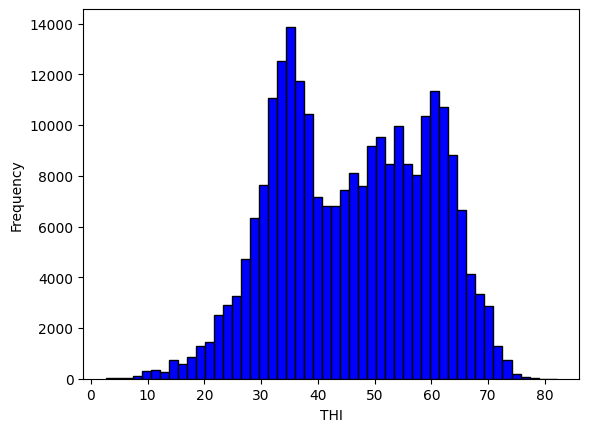

In [19]:
plt.hist(df['MeanTHI_adj'], bins=50, color='blue', edgecolor='black')
plt.xlabel('THI')
plt.ylabel('Frequency')
plt.show()

Find Total Yield when THI is close to 0

* If THI = 0 is less than the breakpoint, the first part of the piecewise_linear function applies:
    - TotalYield=intercept+slope1×THI

* At THI=0THI=0:
    - TotalYield=intercept


In [20]:
# Define the piecewise linear function
def piecewise_linear(thi, intercept, slope1, slope2, breakpoint):
    return np.where(thi < breakpoint,
                    intercept + slope1 * thi,
                    intercept + slope1 * breakpoint + slope2 * (thi - breakpoint))

# Fit the model
popt, _ = curve_fit(piecewise_linear, df['MeanTHI_adj'], df['CR0'], p0=[0.7, 0, -0.01, 61])

# Extract the optimal parameters from the fitted model
intercept, slope1, slope2, breakpoint = popt

# Calculate CR when THI = 0
thi_value = 0
total_yield_at_thi_0 = piecewise_linear(thi_value, intercept, slope1, slope2, breakpoint)

print(f"CR when THI = 0: {total_yield_at_thi_0}")

CR when THI = 0: 0.7638413990672672


Estimate slopes

In [21]:
# Define the breakpoint
breakpoint = 67

# Calculate slope1 (THI < breakpoint)
pre_break = df[df['MeanTHI_adj'] < breakpoint]
slope1 = (pre_break['CR0'].max() - pre_break['CR0'].min()) / \
         (pre_break['MeanTHI_adj'].max() - pre_break['MeanTHI_adj'].min())

# Calculate slope2 (THI >= breakpoint)
post_break = df[df['MeanTHI_adj'] >= breakpoint]
slope2 = (post_break['CR0'].max() - post_break['CR0'].min()) / \
         (post_break['MeanTHI_adj'].max() - post_break['MeanTHI_adj'].min())

print(f"Estimated slope1: {slope1}")
print(f"Estimated slope2: {slope2}")

Estimated slope1: 0.015527804034144194
Estimated slope2: 0.0663560906707318


Confirm slope estimation

Optimized Parameters:
Intercept: 0.76
Slope1 (before breakpoint): -0.00
Slope2 (after breakpoint): -0.00
Breakpoint (THI threshold): 66.85


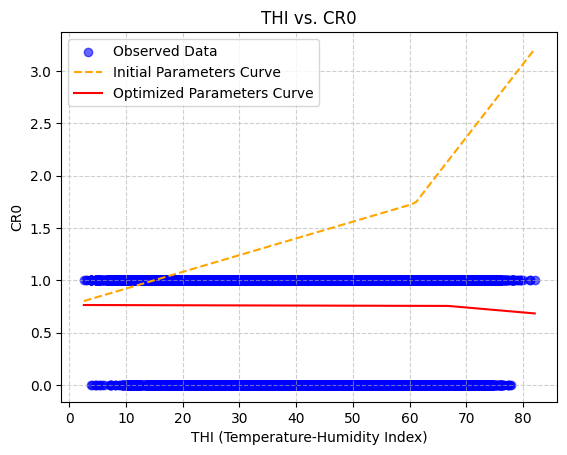

In [22]:
# Define the piecewise linear function
def piecewise_linear(thi, intercept, slope1, slope2, breakpoint):
    return np.where(thi < breakpoint,
                    intercept + slope1 * thi,
                    intercept + slope1 * breakpoint + slope2 * (thi - breakpoint))

# Define initial parameters
p0 = [0.76, 0.016, 0.07, 61]  # Example initial parameters: intercept, slope1, slope2, breakpoint

# Fit the model
popt, _ = curve_fit(piecewise_linear, df['MeanTHI_adj'], df['CR0'], p0=p0)

# Output optimized parameters
print("Optimized Parameters:")
print(f"Intercept: {popt[0]:.2f}")
print(f"Slope1 (before breakpoint): {popt[1]:.2f}")
print(f"Slope2 (after breakpoint): {popt[2]:.2f}")
print(f"Breakpoint (THI threshold): {popt[3]:.2f}")

# Generate THI values for the plot
thi_values = np.linspace(df['MeanTHI_adj'].min(), df['MeanTHI_adj'].max(), 100)

# Compute predictions using initial and optimized parameters
initial_curve = piecewise_linear(thi_values, *p0)
optimized_curve = piecewise_linear(thi_values, *popt)

# Plot observed data
plt.scatter(df['MeanTHI_adj'], df['CR0'], alpha=0.6, label='Observed Data', color='blue')

# Plot initial parameter curve
plt.plot(thi_values, initial_curve, color='orange', linestyle='--', label='Initial Parameters Curve')

# Plot optimized parameter curve
plt.plot(thi_values, optimized_curve, color='red', label='Optimized Parameters Curve')

# Add labels and legend
plt.title('THI vs. CR0')
plt.xlabel('THI (Temperature-Humidity Index)')
plt.ylabel('CR0')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Run with estimated slopes

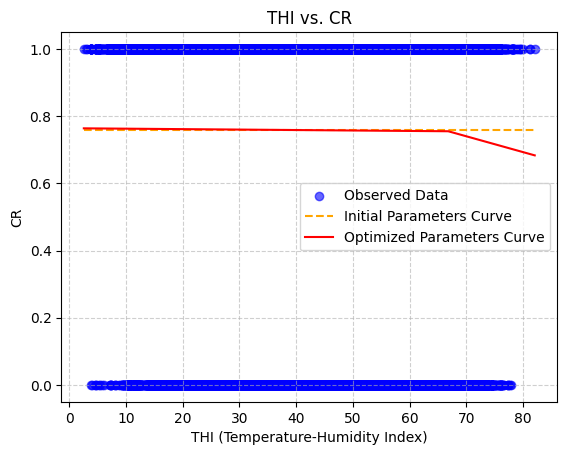

In [23]:
# Define the piecewise linear function
def piecewise_linear(thi, intercept, slope1, slope2, breakpoint):
    return np.where(thi < breakpoint,
                    intercept + slope1 * thi,
                    intercept + slope1 * breakpoint + slope2 * (thi - breakpoint))

# Define initial parameters
p0 = [0.76, -0.00, -0.00, 66.84]  # Example initial parameters: intercept, slope1, slope2, breakpoint

# Fit the model
popt, _ = curve_fit(piecewise_linear, df['MeanTHI_adj'], df['CR0'], p0=p0)

# Generate THI values for the plot
thi_values = np.linspace(df['MeanTHI_adj'].min(), df['MeanTHI_adj'].max(), 100)

# Compute predictions using initial and optimized parameters
initial_curve = piecewise_linear(thi_values, *p0)
optimized_curve = piecewise_linear(thi_values, *popt)

# Plot observed data
plt.scatter(df['MeanTHI_adj'], df['CR0'], alpha=0.6, label='Observed Data', color='blue')

# Plot initial parameter curve
plt.plot(thi_values, initial_curve, color='orange', linestyle='--', label='Initial Parameters Curve')

# Plot optimized parameter curve
plt.plot(thi_values, optimized_curve, color='red', label='Optimized Parameters Curve')

# Add labels and legend
plt.title('THI vs. CR')
plt.xlabel('THI (Temperature-Humidity Index)')
plt.ylabel('CR')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Find THI threshold to use

Estimated THI Threshold: 66.84


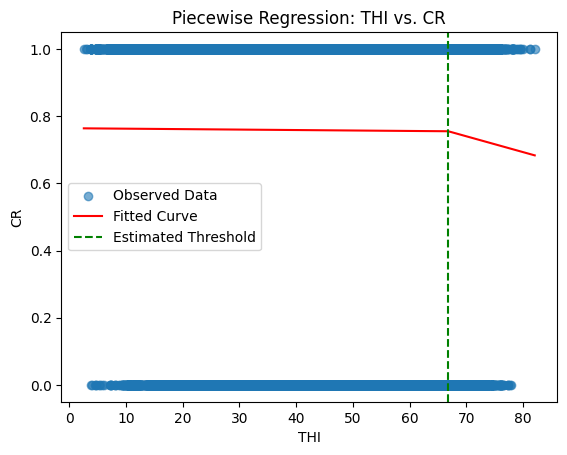

In [24]:
# Define a piecewise linear function
def piecewise_linear(thi, intercept, slope1, slope2, breakpoint):
    return np.where(thi < breakpoint,
                    intercept + slope1 * thi,
                    intercept + slope1 * breakpoint + slope2 * (thi - breakpoint))

# Fit the model
popt, _ = curve_fit(piecewise_linear, df['MeanTHI_adj'], df['CR0'], p0=[0.76, -0.00, -0.00, 66.84])

# Extract the estimated breakpoint (THI threshold)
estimated_threshold = popt[3]
print(f"Estimated THI Threshold: {estimated_threshold}")

# Plot the fitted curve
thi_values = np.linspace(df['MeanTHI_adj'].min(), df['MeanTHI_adj'].max(), 100)
predicted_cr = piecewise_linear(thi_values, *popt)

plt.scatter(df['MeanTHI_adj'], df['CR0'], alpha=0.6, label='Observed Data')
plt.plot(thi_values, predicted_cr, color='red', label='Fitted Curve')
plt.axvline(x=estimated_threshold, color='green', linestyle='--', label='Estimated Threshold')
plt.xlabel('THI')
plt.ylabel('CR')
plt.title('Piecewise Regression: THI vs. CR')
plt.legend()
plt.show()